# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from functools import cmp_to_key
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


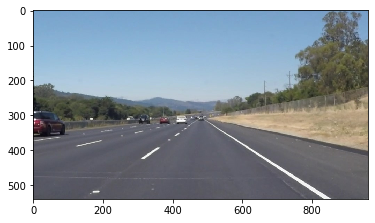

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [4]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
images =['solidWhiteCurve.jpg',
         'solidWhiteRight.jpg',
         'solidYellowCurve.jpg',
         'solidYellowCurve2.jpg',
         'solidYellowLeft.jpg',
         'whiteCarLaneSwitch.jpg']

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [5]:
import math
import numpy.polynomial.polynomial as poly

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines_orig(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines_orig(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_orig(line_img, lines)
    return line_img

def draw_lines(img, lines, color=[255, 0, 0], thickness=2,debug = False):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    height, width, _ = img.shape
    camera_x       = width //2
    camera_y       = height
    min_theta      = 15.0
    max_theta      = 90.0

    left_lines     = []
    right_lines    = []
    other_lines    = []
    left_midpts    = []
    right_midpts   = []
    other_midpts   = []
    compare_key    = cmp_to_key(sort_by_y)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            delta_x = x2-x1
            delta_y = y2-y1
            x_mp    = x1 + (delta_x//2)
            y_mp    = y1 + (delta_y//2)            
            if delta_x != 0:
                slope   = delta_y / delta_x
                theta   = np.arctan(slope) * 180 / np.pi
            elif delta_y < 0:
                slope   = np.Infinity
                theta   = 90.0
            else:
                slope   = -np.Infinity
                theta   = -90.0
#             print('line: ', line[0], ' delta x: ', delta_x, 'delta y:', delta_y, ' tan(theta) = ', slope, ' theta: ' , theta)
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            if (x1 > camera_x + 20) and (x2 > camera_x + 20):
                right_lines.append([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
                right_midpts.append((x_mp, y_mp))
            elif (x1 < camera_x - 20) and (x2 < camera_x - 20):
                left_lines.append ([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
                left_midpts.append((x_mp, y_mp))
            else:
                other_lines.append([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
                other_midpts.append((x_mp, y_mp))
#         if max_theta >= theta > min_theta:
#             right_lines.append([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
#             right_midpts.append((x_mp, y_mp))
#         elif -max_theta < theta <= -min_theta: 
#             left_lines.append ([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
#             left_midpts.append((x_mp, y_mp))
#         else:
#             other_lines.append([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
#             other_midpts.append((x_mp, y_mp))
    
    if debug:
        print(' left lines:')
        for line in left_lines:
            x1,y1,x2,y2, mid_pt, slope, theta = line
            delta_x = x2-x1
            delta_y = y2-y1
            print('line: ', line[:4], ' delta x: ', delta_x, 'delta y:', delta_y, ' tan(theta) = ', round(slope,3), ' theta: ' , round(theta,3), mid_pt)
            cv2.circle(img, mid_pt, radius = 3, color=(0,255,0), thickness=3)

        print(' right lines:')
        for line in right_lines:
            x1,y1,x2,y2,  mid_pt, slope, theta = line
            delta_x = x2-x1
            delta_y = y2-y1
            print('line: ', line[:4], ' delta x: ', delta_x, 'delta y:', delta_y, ' tan(theta) = ', round(slope,3), ' theta: ' , round(theta,3), mid_pt)
            cv2.circle(img, mid_pt, radius = 3, color=(0,255,0), thickness=3)

        print(' other lines:')
        for line in other_lines:
            x1,y1,x2,y2,  mid_pt, slope, theta = line
            delta_x = x2-x1
            delta_y = y2-y1
            print('line: ', line[:4], ' delta x: ', delta_x, 'delta y:', delta_y, ' tan(theta) = ', round(slope,3), ' theta: ' , round(theta,3), mid_pt)
            cv2.circle(img, mid_pt, radius = 3, color=(0,0,255), thickness=2)
    
    right_midpts = sorted(right_midpts, key = compare_key)
    right_fitpts = np.array([right_midpts[0], right_midpts[-1]])
    
    vx,vy,x0,y0 = cv2.fitLine( right_fitpts, distType = cv2.DIST_L2, param = 0, reps = 0.1, aeps=0.01)
    m1 = (y0 - 320)/vy
    m2 = (540 - y0)/vy
    cv2.line(img, (x0-m1*vx, y0-m1*vy), (x0+m2*vx, y0+m2*vy), (255,0,0), thickness = 10, lineType=cv2.LINE_AA)
    
    if debug:
        print('Right mid points : ', right_midpts)
        print('Right fit points : ', right_fitpts, ' midpoint of fit points: ', x_mp, y_mp)
        print('Right lane extent: x0,y0:', x0,y0, ' from :',x0-m1*vx, y0-m1*vy, 'to: ',x0+m2*vx, y0+m2*vy)
    
    left_midpts = sorted(left_midpts, key = compare_key)
    left_fitpts = np.array([left_midpts[0], left_midpts[-1]])
    
    vx,vy,x0,y0 = cv2.fitLine(np.array(left_midpts) , distType = cv2.DIST_L2, param = 0, reps = 0.1, aeps=0.01)
    m1 = (y0 - 320)/vy
    m2 = (540 - y0)/vy
    cv2.line(img, (x0-m1*vx, y0-m1*vy), (x0+m2*vx, y0+m2*vy), (255,0,0), thickness = 10, lineType=cv2.FILLED)

    if debug:
        print('Left midpoints  : ', left_midpts)
        print('Left midpoints  : ', left_fitpts, ' midpoint of fit points: ', x_mp, y_mp)
        print('Left lane extent : x0,y0:', x0,y0, ' from :',x0-m1*vx, y0-m1*vy, 'to: ',x0+m2*vx, y0+m2*vy)        

def sort_by_y(a, b):
    if a[1] > b[1]:
        return -1
    elif a[1] == b[1]:
        if a[0] > b[0]:
            return 1
        else:
            return -1
    else:
        return 1

def sort_by_x(p1, p2):
    if p1[0] > p2[0]:
        return -1
    elif p1[0] == p2[0]:
        if p1[0] > p2[0]:
            return 1
        else:
            return -1
    else:
        return 1
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, debug = False):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, debug = debug)
    return line_img

def clip_hough_lines(img, y_top_limit):
    mask = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    print(img.shape, mask.shape)
    mask[y_top_limit:,...] = 255
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def draw_guidelines(img):  
    """
    helper function to draw marker for camera position and guidelines to assist in 
    marking RoI region
    """
    height, width, _ = img.shape
    midline_x = width //2 
    midline_y = height//2
    cv2.drawMarker(img, (midline_x, height-3),(255,255,0), cv2.MARKER_DIAMOND, markerSize=20, thickness=10)
    cv2.line(img, (midline_x, 0), (midline_x, height), (255,255,0), thickness=1)
    cv2.line(img, (0, midline_y), (width , midline_y), (255,255,0), thickness=2)
    return img
    
def draw_roi_lines(img, vertices):
    """
    helper function to draw lines designating the ROI region
    """
    line_color = (255,0,0)
    img = cv2.line(img, vertices[0], vertices[1], line_color, thickness = 2)
    img = cv2.line(img, vertices[1], vertices[2], line_color, thickness = 2)
    img = cv2.line(img, vertices[2], vertices[3], line_color, thickness = 2)
    img = cv2.line(img, vertices[3], vertices[0], line_color, thickness = 2)
    return img

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [6]:
def detect_lanes(image, debug = False):
    ## Convert image to gray scale
    imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     print('This image is:', type(imgGray), 'with dimensions:', imgGray.shape)

    ## Gaussian Blurring
    blurKernel = 11
    imgBlurred = gaussian_blur(imgGray, blurKernel)

    ## Canny detection
    lowThrehold   = 80
    highThreshold = 140
    imgCanny      = canny(imgBlurred, lowThrehold, highThreshold)


    ## define region of interest and call masking fuction
    height, width, _   = image.shape
    camera_x           = width //2
    camera_y           = height
    x_offset_top_left  = 80
    x_offset_top_right = 90
    y_offset_top       = 350
    
    x_offset_bot_left  = 380
    x_offset_bot_right = 440
    y_offset_bottom    = image.shape[0]

    RoI_vertices_list = [(camera_x - x_offset_bot_left , y_offset_bottom-1), 
                         (camera_x - x_offset_top_left , y_offset_top), 
                         (camera_x + x_offset_top_right, y_offset_top), 
                         (camera_x + x_offset_bot_right, y_offset_bottom-1) ]
    RoI_vertices      = np.array([RoI_vertices_list],dtype = np.int32)
    if debug:
        print(' RoI vertices : ', RoI_vertices_list)
        print(' Vertices     : ', RoI_vertices.shape, RoI_vertices)
    
    imgMasked = region_of_interest(imgCanny, RoI_vertices)

    imgRoI = np.copy(image)
    imgRoI = draw_roi_lines(imgRoI, RoI_vertices_list)
    imgRoI = draw_guidelines(imgRoI)

    ## Hough Tranformation 
    rho           = 1
    theta         = np.pi / 180
    threshold     = 5
    min_line_len  = 5
    max_line_gap  = 20

    ## Run original hough_lines function
    ## Overlay and display Hough Transformed image over original image:
    imgHoughOrig = hough_lines_orig(imgMasked, rho, theta, threshold, min_line_len, max_line_gap)
    imgHoughOrigOverlay = weighted_img(imgHoughOrig, image, α=0.8, β=0.7, γ=0.)

    ## Run new hough_lines function, detecting extrapolated lanes
    ## Overlay and display Hough Transformed image over original image:
    imgHough = hough_lines(imgMasked, rho, theta, threshold, min_line_len, max_line_gap, debug = debug)
    imgOverlay = weighted_img(imgHough, image, α=0.8, β=0.7, γ=0.)

    if debug:
        ## Display intermediate results
        fig = plt.figure(figsize=(25,15))
        plt.subplot(331);plt.imshow(image)
        plt.subplot(332);plt.imshow(imgGray, cmap = 'gray'); plt.title(' imgGray: Gray Scale Image')
        plt.subplot(333);plt.imshow(imgBlurred, cmap = 'gray'); plt.title(' imgBlurred: Gaussian blurring')

        plt.subplot(334);plt.imshow(imgCanny, cmap = 'gray'); plt.title(' imgCanny: Canny Detection')
        plt.subplot(335);plt.imshow(imgRoI ); plt.title(' imgRoI: Region of Interest')
        plt.subplot(336);plt.imshow(imgMasked , cmap = 'gray'); plt.title(' imgMasked: Masked image')

        plt.subplot(337);plt.imshow(imgHoughOrig, cmap = 'gray'); plt.title(' imgHough: Hough Lines Detected')
        plt.subplot(338);plt.imshow(imgHoughOrigOverlay ); plt.title(' Orig Image w/ Hough Lines ')
        plt.subplot(339);plt.imshow(imgHough ); plt.title(' Hough detected lines extrpolated ')
        plt.show()
        
    return imgOverlay

Image : solidWhiteRight.jpg    with dimensions: (540, 960, 3)
 RoI vertices :  [(100, 539), (400, 350), (570, 350), (920, 539)]
 Vertices     :  (1, 4, 2) [[[100 539]
  [400 350]
  [570 350]
  [920 539]]]
 left lines:
line:  [310, 422, 355, 392]  delta x:  45 delta y: -30  tan(theta) =  -0.667  theta:  -33.69 (332, 407)
line:  [171, 520, 178, 515]  delta x:  7 delta y: -5  tan(theta) =  -0.714  theta:  -35.538 (174, 517)
line:  [324, 422, 361, 392]  delta x:  37 delta y: -30  tan(theta) =  -0.811  theta:  -39.036 (342, 407)
line:  [407, 356, 413, 351]  delta x:  6 delta y: -5  tan(theta) =  -0.833  theta:  -39.806 (410, 353)
line:  [355, 400, 362, 394]  delta x:  7 delta y: -6  tan(theta) =  -0.857  theta:  -40.601 (358, 397)
line:  [181, 521, 188, 516]  delta x:  7 delta y: -5  tan(theta) =  -0.714  theta:  -35.538 (184, 518)
line:  [341, 410, 359, 396]  delta x:  18 delta y: -14  tan(theta) =  -0.778  theta:  -37.875 (350, 403)
line:  [310, 423, 333, 408]  delta x:  23 delta y: -15  

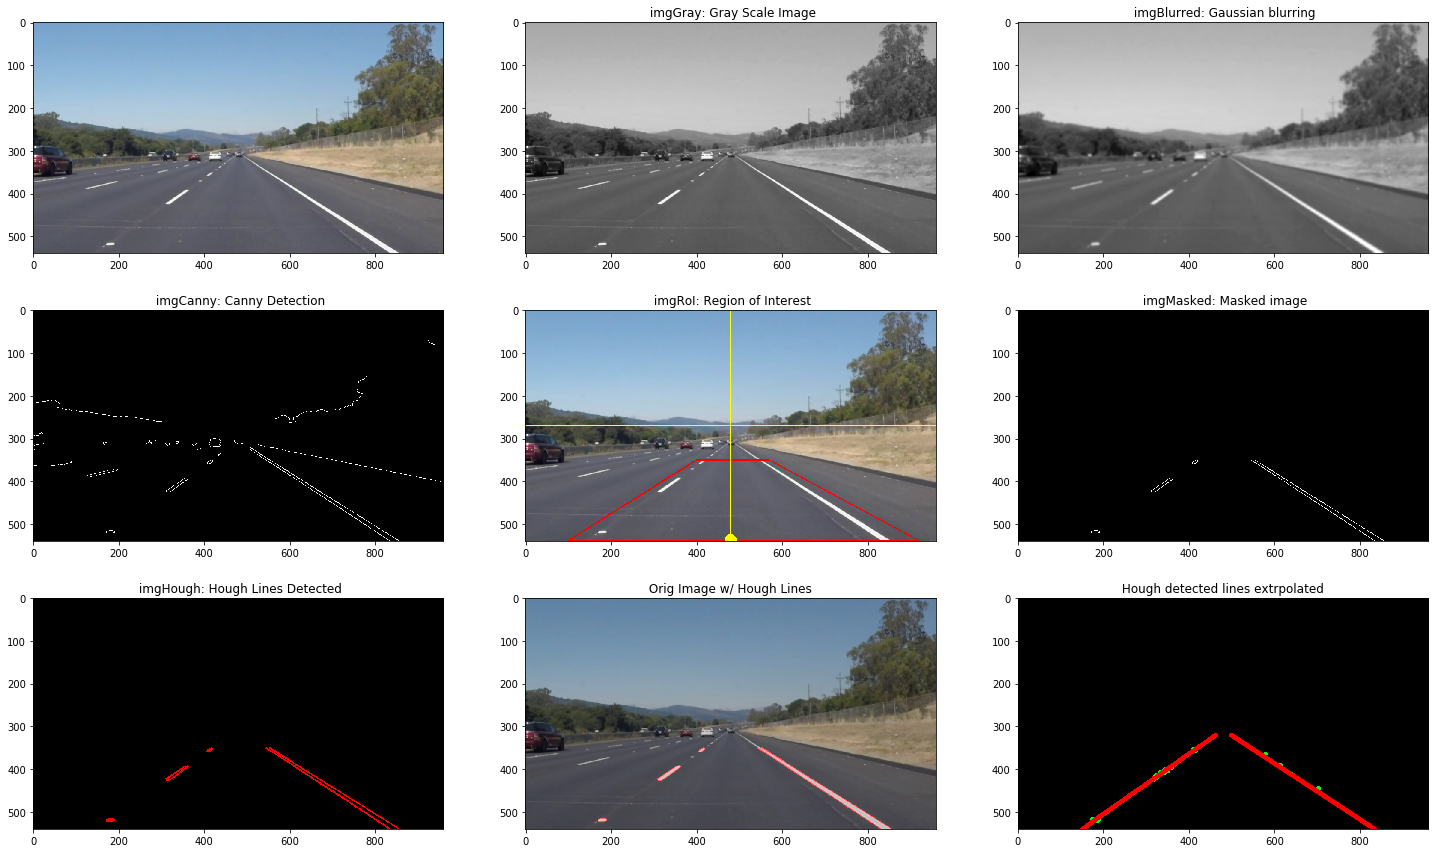

Text(0.5, 1.0, 'solidWhiteRight.jpg with detected lanes')

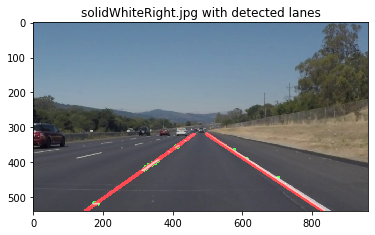

In [7]:
image_id = 1
image = mpimg.imread('test_images/'+images[image_id])
print('Image :', images[image_id], '   with dimensions:', image.shape)    
imgDetected = detect_lanes(image, debug= True)
plt.imshow(imgDetected); plt.title(images[image_id]+' with detected lanes')

In [8]:
def sort_by_y(p1, p2):
    if p1[1] > p2[1]:
        return -1
    elif p1[1] == p2[1]:
        if p1[0] > p2[0]:
            return 1
        else:
            return -1
    else:
        return 1

def sort_by_x(p1, p2):
    if p1[0] > p2[0]:
        return -1
    elif p1[0] == p2[0]:
        if p1[1] < p2[1]:
            return 1
        else:
            return -1
    else:
        return 1

In [44]:
p = [(786, 509), (786, 505), (786,515), (721, 466), (702, 444), (640, 412), (612, 390), (577, 365), (550, 355), (550, 360), (550, 350)]
l = [(180, 520), (187, 519), (181, 518), (184, 518), (185, 518), 
     (174, 517), (174, 520), (174, 515), (177, 516), (314, 424), 
     (316, 424), (324, 420), (321, 415), (332, 407), (342, 407), 
     (348, 403), (350, 403), (342, 401), (358, 397), (415, 356), (412, 355), (410, 353), (412, 353)]
p = [(875, 517), (862, 523), (899, 559), (929, 557), (887, 510), (934, 567), (902, 550), (862, 524)]

In [45]:
print(sorted(p, key = cmp_to_key(sort_by_y)))
print(sorted(p, key = cmp_to_key(sort_by_x)))

[(934, 567), (899, 559), (929, 557), (902, 550), (862, 524), (862, 523), (875, 517), (887, 510)]
[(934, 567), (929, 557), (902, 550), (899, 559), (887, 510), (875, 517), (862, 524), (862, 523)]


In [11]:
print(sorted(l, key = cmp_to_key(sort_by_x)))

[(415, 356), (412, 355), (412, 353), (410, 353), (358, 397), (350, 403), (348, 403), (342, 407), (342, 401), (332, 407), (324, 420), (321, 415), (316, 424), (314, 424), (187, 519), (185, 518), (184, 518), (181, 518), (180, 520), (177, 516), (174, 520), (174, 517), (174, 515)]


Image : solidWhiteCurve.jpg    with dimensions: (540, 960, 3)
Image : solidWhiteRight.jpg    with dimensions: (540, 960, 3)
Image : solidYellowCurve.jpg    with dimensions: (540, 960, 3)
Image : solidYellowCurve2.jpg    with dimensions: (540, 960, 3)
Image : solidYellowLeft.jpg    with dimensions: (540, 960, 3)
Image : whiteCarLaneSwitch.jpg    with dimensions: (540, 960, 3)


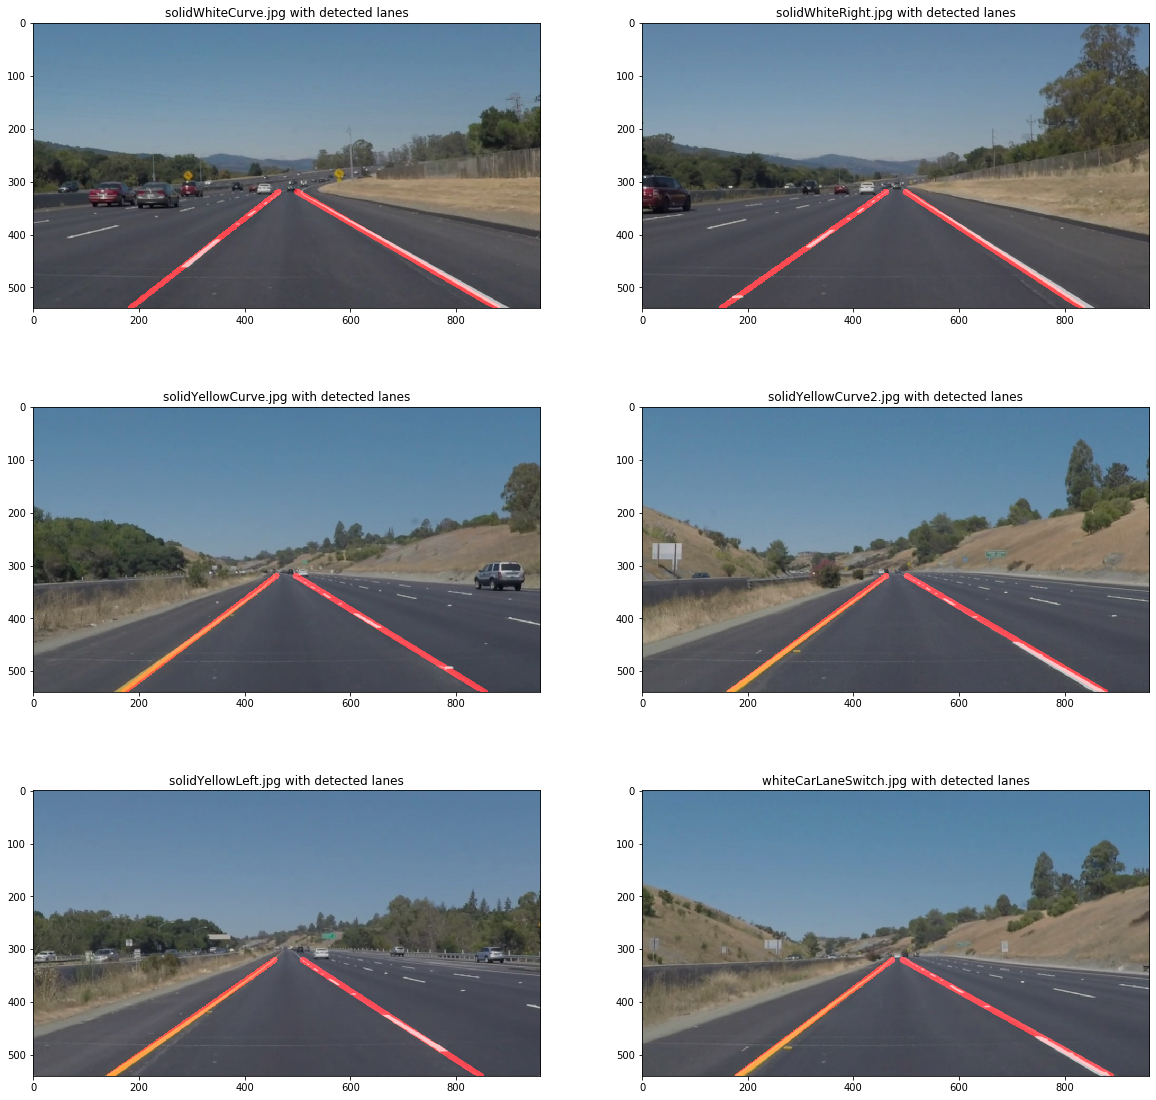

In [12]:
fig = plt.figure(figsize=(20,20))

for image_id in [0,1,2,3,4,5]:
    image = mpimg.imread('test_images/'+images[image_id])
    print('Image :', images[image_id], '   with dimensions:', image.shape)    
    imgDetected = detect_lanes(image)
    plt.subplot(321+image_id);plt.imshow(imgDetected); plt.title(images[image_id]+' with detected lanes')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [13]:
# Import everything needed to edit/save/watch video clips
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def process_image(image,  debug = False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    ## Convert image to gray scale
    imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     print('This image is:', type(imgGray), 'with dimensions:', imgGray.shape)

    ## Gaussian Blurring
    blurKernel = 11
    imgBlurred = gaussian_blur(imgGray, blurKernel)

    ## Canny detection
    lowThrehold   = 80
    highThreshold = 140
    imgCanny      = canny(imgBlurred, lowThrehold, highThreshold)


    ## define region of interest and call masking fuction
    height, width, _   = image.shape
    camera_x           = width //2
    camera_y           = height
#     x_offset_top_left  = 100
#     x_offset_top_right = 100
#     y_offset_top       = 350
    
#     x_offset_bot_left  = 380
#     x_offset_bot_right = 460
    
    x_offset_top_left  = 80
    x_offset_top_right = 90
    y_offset_top       = 350
    
    x_offset_bot_left  = 380
    x_offset_bot_right = 440    
    y_offset_bottom    = image.shape[0]


    RoI_vertices_list = [(camera_x - x_offset_bot_left , y_offset_bottom-1), 
                     (camera_x - x_offset_top_left , y_offset_top), 
                     (camera_x + x_offset_top_right, y_offset_top), 
                     (camera_x + x_offset_bot_right, y_offset_bottom-1) ]
    if debug:
        print('RoI RoI_vertices     : ',RoI_vertices_list)

    RoI_vertices = np.array([RoI_vertices_list],dtype = np.int32)
    imgMasked = region_of_interest(imgCanny, RoI_vertices)

    imgRoI = np.copy(image)
    imgRoI = draw_roi_lines(imgRoI, RoI_vertices_list)
    imgRoI = draw_guidelines(imgRoI)

    ## Hough Tranformation 
    rho           = 1
    theta         = np.pi / 180
    threshold     = 5
    min_line_len  = 5
    max_line_gap  = 20

    ## Run original hough_lines function
    ## Overlay and display Hough Transformed image over original image:
    imgHoughOrig = hough_lines_orig(imgMasked, rho, theta, threshold, min_line_len, max_line_gap)
    imgHoughOrigOverlay = weighted_img(imgHoughOrig, image, α=0.8, β=0.7, γ=0.)

    ## Run new hough_lines function, detecting extrapolated lanes
    ## Overlay and display Hough Transformed image over original image:
    imgHough = hough_lines(imgMasked, rho, theta, threshold, min_line_len, max_line_gap, debug = debug)
    draw_roi_lines(imgHough, RoI_vertices_list)
    draw_guidelines(imgHough)
    
    result = weighted_img(imgHough, image, α=0.8, β=0.7, γ=0.)

    if debug:
        ## Display intermediate results
        fig = plt.figure(figsize=(25,15))
        plt.subplot(331);plt.imshow(image)
        plt.subplot(332);plt.imshow(imgGray, cmap = 'gray'); plt.title(' imgGray: Gray Scale Image')
        plt.subplot(333);plt.imshow(imgBlurred, cmap = 'gray'); plt.title(' imgBlurred: Gaussian blurring')

        plt.subplot(334);plt.imshow(imgCanny, cmap = 'gray'); plt.title(' imgCanny: Canny Detection')
        plt.subplot(335);plt.imshow(imgRoI ); plt.title(' imgRoI: Region of Interest')
        plt.subplot(336);plt.imshow(imgMasked , cmap = 'gray'); plt.title(' imgMasked: Masked image')

        plt.subplot(337);plt.imshow(imgHoughOrig, cmap = 'gray'); plt.title(' imgHough: Hough Lines Detected')
        plt.subplot(338);plt.imshow(imgHoughOrigOverlay ); plt.title(' Orig Image w/ Hough Lines ')
        plt.subplot(339);plt.imshow(imgHough ); plt.title(' Hough detected lines extrpolated ')
        plt.show()
        
    return result

In [ ]:
def close_clip(vidya_clip):
    # noinspection PyBroadException
    try:
        vidya_clip.reader.close()
        del vidya_clip.reader
        if vidya_clip.audio is not None:
            vidya_clip.audio.reader.close_proc()
            del vidya_clip.audio
        del vidya_clip
    except Exception:
        # sys.exc_clear()
        pass                

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
# Import everything needed to edit/save/watch video clips
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 25.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 10.7 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Optional Challenge Development

In [31]:
def process_image_modified(image,  debug = False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    ## Convert image to gray scale
    imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     print('This image is:', type(imgGray), 'with dimensions:', imgGray.shape)
    
    if debug:
        ## Display intermediate results
        fig = plt.figure(figsize=(25,15))
        plt.subplot(331);plt.imshow(image)
        plt.subplot(332);plt.imshow(imgGray, cmap = 'gray'); plt.title(' imgGray: Gray Scale Image')
    
    ## Gaussian Blurring
    blurKernel = 11
    imgBlurred = gaussian_blur(imgGray, blurKernel)
    if debug:
        plt.subplot(333);plt.imshow(imgBlurred, cmap = 'gray'); plt.title(' imgBlurred: Gaussian blurring')
        
    ## Canny detection
    lowThrehold   = 80
    highThreshold = 140
    imgCanny      = canny(imgBlurred, lowThrehold, highThreshold)
    if debug:
        plt.subplot(334);plt.imshow(imgCanny, cmap = 'gray'); plt.title(' imgCanny: Canny Detection')


    ## define region of interest and call masking fuction
    height, width, _   = image.shape
    camera_x           = width //2
    camera_y           = height - 50
    x_offset_top_left  = 100
    x_offset_top_right = 130
    
    x_offset_bot_left  = 460
    x_offset_bot_right = 480
    
    y_offset_top       = 470 ## (6*height)//10
    y_offset_bottom    = camera_y
    camera_info        = [camera_x,camera_y, y_offset_top, y_offset_bottom]

    RoI_top_left       = (camera_x - x_offset_top_left , y_offset_top)
    RoI_top_right      = (camera_x + x_offset_top_right, y_offset_top)
    RoI_bot_left       = (camera_x - x_offset_bot_left , y_offset_bottom)
    RoI_bot_right      = (camera_x + x_offset_bot_right, y_offset_bottom)
    RoI_vertices_list  = [RoI_top_left, RoI_top_right, RoI_bot_right, RoI_bot_left]
    
    if debug:
        print(' y_offset_top :', y_offset_top)        
        print('RoI vertices     : ',RoI_vertices_list)

    RoI_vertices = np.array([RoI_vertices_list],dtype = np.int32)
    ## Mask imgCanny to area defined by RoI vertices
    imgMasked = region_of_interest(imgCanny, RoI_vertices)
    if debug:
        plt.subplot(336);plt.imshow(imgMasked , cmap = 'gray'); plt.title(' imgMasked: Masked image')

    imgRoI = np.copy(image)
    imgRoI = draw_roi_lines(imgRoI, RoI_vertices_list)
    imgRoI = draw_guidelines(imgRoI)
    if debug:
        plt.subplot(335);plt.imshow(imgRoI ); plt.title(' imgRoI: Region of Interest')

    ## Hough Tranformation 
    rho           = 1
    theta         = np.pi / 180
    threshold     = 5
    min_line_len  = 20
    max_line_gap  = 20

    ## Run original hough_lines function
    ## Overlay and display Hough Transformed image over original image:
    imgHoughOrig = hough_lines_orig(imgMasked, rho, theta, threshold, min_line_len, max_line_gap)
    if debug:
        plt.subplot(337);plt.imshow(imgHoughOrig, cmap = 'gray'); plt.title(' imgHough: Hough Lines Detected')
        
    imgHoughOrigOverlay = weighted_img(imgHoughOrig, image, α=0.8, β=0.7, γ=0.)
    if debug:
        plt.subplot(338);plt.imshow(imgHoughOrigOverlay ); plt.title(' Orig Image w/ Hough Lines ')

    ## Run new hough_lines function, detecting extrapolated lanes
    ## Overlay and display Hough Transformed image over original image:
#     imgHough, imgHoughDebug = hough_lines_v3(imgMasked, rho, theta, threshold, min_line_len, max_line_gap, camera_info, debug = debug)
    imgHough, imgHoughDebug = hough_lines_v2(imgMasked, rho, theta, threshold, min_line_len, max_line_gap, camera_info, debug = debug)
    
    draw_roi_lines(imgHough, RoI_vertices_list)
    draw_guidelines(imgHough)
    
    result = weighted_img(imgHough, image, α=0.8, β=0.7, γ=0.)

    if debug:
        plt.subplot(339);plt.imshow(imgHough); plt.title(' Hough detected lines extrapolated ')
        plt.show()
        
    if debug:
        fig = plt.figure(figsize=(20,22))
        plt.subplot(211);plt.imshow(imgHoughDebug); plt.title(' Hough detected lines extrpolated ')
        plt.subplot(212);plt.imshow(imgHough); plt.title(' Hough detected lines extrpolated ');plt.show()

    return result

In [19]:
from statistics import mean, median, median_grouped

def draw_lines_v3(img, lines,  camera_info, color=[255, 0, 0], thickness=2,debug = False):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    height, width, _ = img.shape
    camera_x,camera_y, y_offset_top, y_offset_bottom = camera_info

    min_theta      = 15.0
    max_theta      = 90.0

    left_lines     = []
    right_lines    = []
    other_lines    = []
    left_midpts    = []
    right_midpts   = []
    other_midpts   = []
    right_points   = [] 
    left_points    = [] 
    other_points   = []
    sort_on_x      = cmp_to_key(sort_by_x)
    sort_on_y      = cmp_to_key(sort_by_y)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            delta_x = x2-x1
            delta_y = y2-y1
            x_mp    = x1 + (delta_x//2)
            y_mp    = y1 + (delta_y//2)            
            if delta_x != 0:
                slope   = delta_y / delta_x
                theta   = np.arctan(slope) * 180 / np.pi
            elif delta_y < 0:
                slope   = np.Infinity
                theta   = 90.0
            else:
                slope   = -np.Infinity
                theta   = -90.0
#             print('line: ', line[0], ' delta x: ', delta_x, 'delta y:', delta_y, ' tan(theta) = ', slope, ' theta: ' , theta)
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            if (x1 > camera_x + 20) and (x2 > camera_x + 20) and  (max_theta >= theta > min_theta):
                right_points.extend([[x1,y1],[x2,y2]])
                right_lines.append([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
                right_midpts.append((x_mp, y_mp))
            elif (x1 < camera_x - 20) and (x2 < camera_x - 20) and (-max_theta < theta <= -min_theta):
                left_points.extend([[x1,y1],[x2,y2]])                
                left_lines.append ([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
                left_midpts.append((x_mp, y_mp))
            else:
                other_points.extend([[x1,y1],[x2,y2]])                
                other_lines.append([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
                other_midpts.append((x_mp, y_mp))
                
#         if max_theta >= theta > min_theta:
#             right_lines.append([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
#             right_midpts.append((x_mp, y_mp))
#         elif -max_theta < theta <= -min_theta: 
#             left_lines.append ([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
#             left_midpts.append((x_mp, y_mp))
#         else:
#             other_lines.append([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
#             other_midpts.append((x_mp, y_mp))
    
    if debug:
        print(' left lines:')
        for line in left_lines:
            x1,y1,x2,y2, mid_pt, slope, theta = line
            delta_x = x2-x1
            delta_y = y2-y1
            print('line: ', line[:4], ' delta x: ', delta_x, 'delta y:', delta_y, 'length :', round(np.sqrt(delta_x**2+delta_y**2),3), 
                  ' tan(theta) = ', round(slope,3), ' theta: ' , round(theta,3), mid_pt)
            cv2.line(img, (x1,y1), (x2,y2), (255,255,0), thickness = 1, lineType=cv2.LINE_AA)  ## yellow
            cv2.circle(img, mid_pt, radius = 3, color=(255,0,0), thickness=4 )  ## Red

        print(' right lines:')
        for line in right_lines:
            x1,y1,x2,y2,  mid_pt, slope, theta = line
            delta_x = x2-x1
            delta_y = y2-y1
            print('line: ', line[:4], ' delta x: ', delta_x, 'delta y:', delta_y, 'length :', round(np.sqrt(delta_x**2+delta_y**2),3), 
                  ' tan(theta) = ', round(slope,3), ' theta: ' , round(theta,3), mid_pt)
            cv2.line(img, (x1,y1), (x2,y2), (0,255,255), thickness = 1, lineType=cv2.LINE_AA)  ## cyan
            cv2.circle(img, mid_pt, radius = 3, color=(0,255,0), thickness=4)   ## Green

        print(' other lines:')
        for line in other_lines:
            x1,y1,x2,y2,  mid_pt, slope, theta = line
            delta_x = x2-x1
            delta_y = y2-y1
            print('line: ', line[:4], ' delta x: ', delta_x, 'delta y:', delta_y, ' tan(theta) = ', round(slope,3), ' theta: ' , round(theta,3), mid_pt)
#             cv2.line(img, (x1,y1), (x2,y2), (255,0,255), thickness = 2, lineType=cv2.LINE_AA)  ## magenta
#             cv2.circle(img, mid_pt, radius = 3, color=(0,0,255), thickness=2)   ## Blue
    
    debug_img = np.copy(img)
     
    right_midpts = np.array(sorted(right_midpts, key = sort_on_x))
    right_points = np.array(sorted(right_points, key = sort_on_x))

#     right_fitpts = np.array([right_midpts[0], right_midpts[-1]])
#     right_fitpts = np.array([right_points[0], right_points[-1]])
    right_fitpts = right_points
    
    
    
    left_midpts = np.array(sorted(left_midpts, key = sort_on_x))
    left_points = np.array(sorted(left_points, key = sort_on_x))
#     left_fitpts = np.array([left_midpts[0], left_midpts[-1]])
#     left_fitpts = np.array([left_points[0], left_points[-1]])
    left_fitpts = left_points
    
    if debug:
        print('Right midpoints  : ', left_midpts)
    
    draw_extrpolated_lane(img, right_fitpts, y_offset_top, y_offset_bottom, debug = debug)

    if debug:
        print('Left midpoints  : ', left_midpts)
    
    draw_extrpolated_lane(img, left_fitpts, y_offset_top, y_offset_bottom, debug = debug)

    return debug_img

def draw_extrpolated_lane(img, fit_points, y_offset_top, y_offset_bottom, debug = False):   
    ## possible distTypes are : L2, L1 , L12, FAIR, WELSCH, HUBER
    
    if len(fit_points) == 0:
        return
    vx,vy,x0,y0 = cv2.fitLine( fit_points, distType = cv2.DIST_L2, param = 0, reps = 0.1, aeps=0.01)
    
    m1 = (y0 - y_offset_top)/vy
    m2 = (y_offset_bottom - y0)/vy
    
    if debug:
        print('      fit points : ', fit_points, ' m1: ', m1, 'm2: ', m2, 'vx,vy,x0,y0:', vx,vy,x0,y0 )
        print('      lane extent: x0,y0:', x0,y0, ' from :',x0-m1*vx, y0-m1*vy, 'to: ',x0+m2*vx, y0+m2*vy)
        
    cv2.line(img, (x0-m1*vx, y0-m1*vy), (x0+m2*vx, y0+m2*vy), (255,0,0), thickness = 10, lineType=cv2.LINE_AA)
    
    
def hough_lines_v3(img, rho, theta, threshold, min_line_len, max_line_gap, camera_info, debug = False):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    debug_img = draw_lines_v3(line_img, lines, camera_info, debug = debug)
    return line_img, debug_img

In [20]:
cap = cv2.VideoCapture('test_videos/challenge.mp4')
# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

In [21]:
retval=cap.set(cv2.CAP_PROP_POS_MSEC,600.0)
print(retval)
print(cap.get(cv2.CAP_PROP_POS_FRAMES))

print(cap.get(cv2.CAP_PROP_POS_FRAMES))
cap.set(cv2.CAP_PROP_POS_FRAMES,104)
print(cap.get(cv2.CAP_PROP_POS_FRAMES))

True
15.0
15.0
104.0


In [22]:
ret, frameBGR = cap.read()
image = cv2.cvtColor(frameBGR, cv2.COLOR_BGR2RGB)

(720, 1280, 3)
current frame:  104.0  time(ms):  4160.0      0.04 1280.0 720.0 25.0 828601953.0 251.0 251.0
   with dimensions: (720, 1280, 3)
 y_offset_top : 470
RoI vertices     :  [(540, 470), (770, 470), (1120, 670), (180, 670)]


NameError: name 'compare_by_y' is not defined

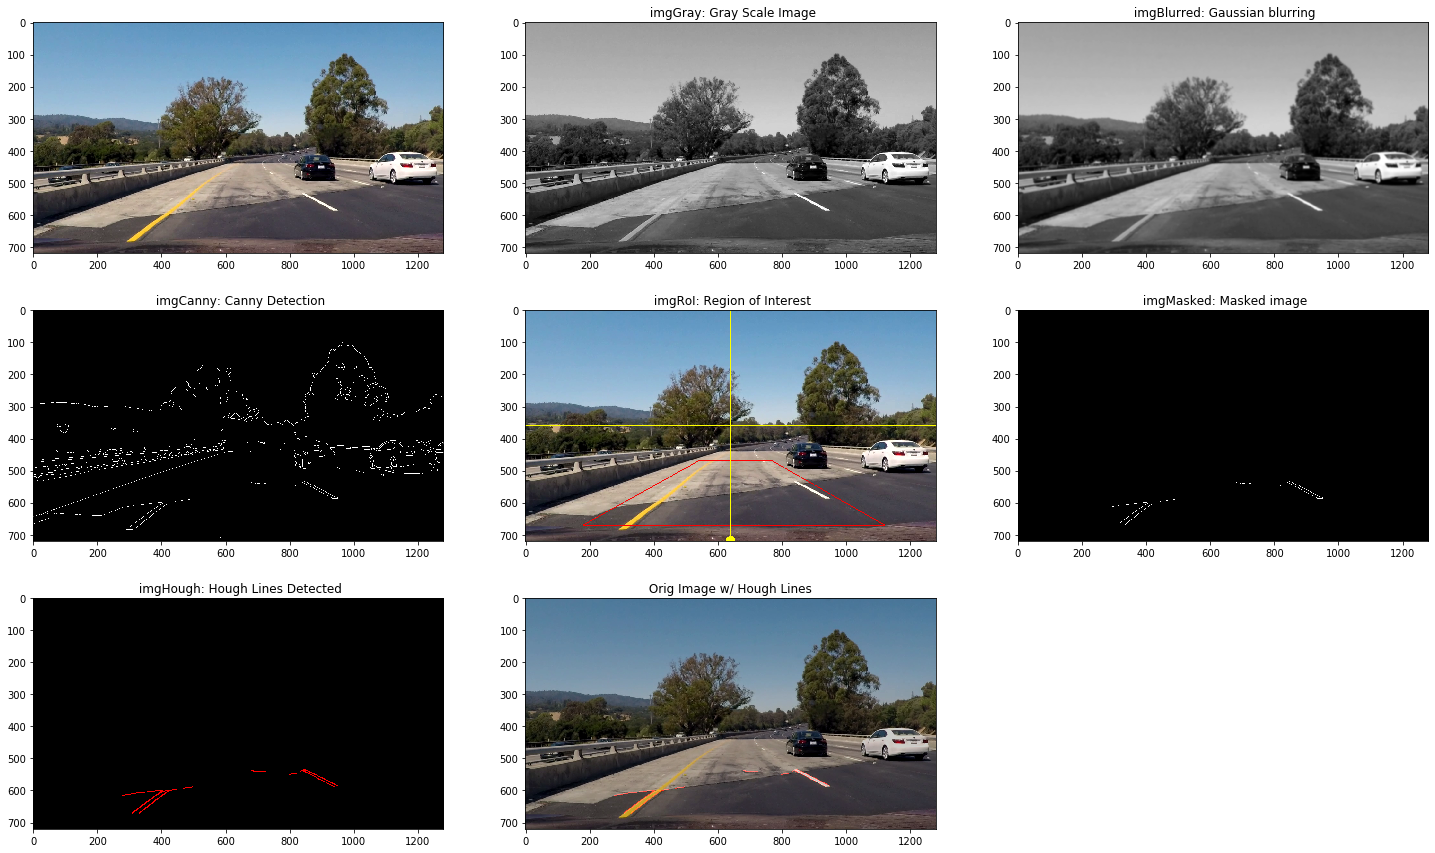

In [37]:
print(image.shape)
print('current frame: ', cap.get(1)-1, ' time(ms): ', cap.get(0),'    ',cap.get(2),cap.get(3),cap.get(4),cap.get(5),cap.get(6), cap.get(7), cap.get(cv2.CAP_PROP_FRAME_COUNT))
# imgBright = cv2.addWeighted( image,   1.5, image, 0, 50)
# imgGray = cv2.cvtColor(imgBright, cv2.COLOR_BGR2GRAY)

# plt.imshow(image);plt.show()
# plt.imshow(imgBright);plt.show()
# plt.imshow(imgGray, cmap='gray');plt.show()

print('   with dimensions:', image.shape)    
imgDetected = process_image_modified(image, debug= True)
fig = plt.figure(figsize=(20,10))
plt.imshow(imgDetected); plt.title(images[image_id]+' with detected lanes')

In [ ]:
# image_id = 0
# image = mpimg.imread('test_images/'+images[image_id])
# print('Image :', images[image_id])
# image = frameBGR
# print('   with dimensions:', image.shape)    
# imgDetected = process_image_modified(image, debug= True)
# plt.imshow(imgDetected); plt.title(images[image_id]+' with detected lanes')

In [ ]:
# fig = plt.figure(figsize=(20,20))

# for image_id in [0,1,2,3,4,5]:
#     image = mpimg.imread('test_images/'+images[image_id])
#     print('Image :', images[image_id], '   with dimensions:', image.shape)    
#     imgDetected = process_image_modified(image)
#     plt.subplot(321+image_id);plt.imshow(imgDetected); plt.title(images[image_id]+' with detected lanes')

###  Run challenge video with modified code

In [24]:
challenge_output_modified = 'test_videos_output/challenge_modified.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)

In [25]:
clip4 = VideoFileClip('test_videos/challenge.mp4')

In [26]:
challenge_clip_modified = clip4.fl_image(process_image_modified)

In [27]:
%time challenge_clip_modified.write_videofile(challenge_output_modified, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_modified.mp4
[MoviePy] Writing video test_videos_output/challenge_modified.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 27.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_modified.mp4 

Wall time: 9.95 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output_modified))

### `draw_lines_v2`

In [50]:
from statistics import mean, median, median_grouped
def draw_lines_v2(img, lines, camera_info, color=[255, 0, 0], thickness=2, debug = False):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    height, width, _ = img.shape
    camera_x,camera_y, y_offset_top, y_offset_bottom = camera_info
    min_theta      = 15.0
    max_theta      = 90.0

    left_lines     = []
    right_lines    = []
    other_lines    = []
    
    left_midpts    = []
    right_midpts   = []
    other_midpts   = []
    
    left_slopes    = []
    right_slopes   = []
    
    left_slope_avg = 0.0
    right_slope_avg= 0.0
    draw_lane_y0   = 320    ## y0 of detected lane that will be overlaid on image 
    draw_lane_y1   = 540    ## y0 of detected lane that will be overlaid on image 
    sort_on_x      = cmp_to_key(sort_by_x)
    sort_on_y      = cmp_to_key(sort_by_y)
        
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            delta_x = x2-x1
            delta_y = -(y2-y1)   ## because the Y axis is inverted
            x_mp    = x1 + (delta_x//2)
            y_mp    = y1 + (delta_y//2)            
            if delta_x != 0:
                slope   = delta_y / delta_x
                theta   = np.arctan(slope) * 180 / np.pi
            elif delta_y > 0:
                slope   = np.Infinity
                theta   = 90.0
            else:
                slope   = -np.Infinity
                theta   = -90.0
            print('line: ', line[0], ' delta x: ', delta_x, 'delta y:', delta_y, ' tan(theta) = ', slope, ' theta: ' , theta)
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)
#             if (x1 > camera_x + 20) and (x2 > camera_x + 20):
#                 right_lines.append([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
#                 right_midpts.append((x_mp, y_mp))
#             elif (x1 < camera_x - 20) and (x2 < camera_x - 20):
#                 left_lines.append ([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
#                 left_midpts.append((x_mp, y_mp))
#             else:
#                 other_lines.append([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
#                 other_midpts.append((x_mp, y_mp))

            if -max_theta < theta < -min_theta:
    #         if (x1 > camera_x + 20) and (x2 > camera_x + 20):
                right_lines.append([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
                right_midpts.append((x_mp, y_mp))
                right_slopes.append(slope)
            elif max_theta > theta > min_theta:
    #         elif (x1 < camera_x - 20) and (x2 < camera_x - 20):            
                left_lines.append ([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
                left_midpts.append((x_mp, y_mp))
                left_slopes.append(slope)
            else:
                other_lines.append([x1,y1,x2,y2, (x_mp, y_mp), slope, theta])
                other_midpts.append((x_mp, y_mp))

    right_slope_mean   = mean(right_slopes)
    left_slope_mean    = mean(left_slopes)
    right_slope_median = median(right_slopes)
    left_slope_median  = median(left_slopes)
    
    left_slope  = left_slope_mean
    right_slope = right_slope_mean
    
    if debug:
        print('\nLeft lines  :')
        print('-'*20)
        print('Avg Slope   : ', left_slope_mean, ' Avg_theta: ', np.arctan(left_slope_mean) * 180 / np.pi, ' degrees')
        print('Median Slope: ', left_slope_median, ' Avg_theta: ', np.arctan(left_slope_median) * 180 / np.pi, ' degrees')
        print('Slopes      : ', left_slopes)
        for line in left_lines:
            x1,y1,x2,y2, mid_pt, slope, theta = line
            delta_x = x2-x1
            delta_y = -(y2-y1)
            print('line: ', line[:4], ' delta x: ', delta_x, 'delta y:', delta_y, ' tan(theta) = ', round(slope,3), ' theta: ' , round(theta,3), mid_pt)
            cv2.circle(img, mid_pt, radius = 3, color=(255,0,0), thickness=3)
        
        print('\nRight lines :')
        print('-'*20)
        print('Avg Slope   : ', right_slope_mean  , ' Avg_theta: ', np.arctan(right_slope_mean) * 180 / np.pi, ' degrees')
        print('Median Slope: ', right_slope_median, ' Avg_theta: ', np.arctan(right_slope_median) * 180 / np.pi, ' degrees')
        print('Slopes      : ', right_slopes)
        for line in right_lines:
            x1,y1,x2,y2,  mid_pt, slope, theta = line
            delta_x = x2-x1
            delta_y = -(y2-y1)
            print('line: ', line[:4], ' delta x: ', delta_x, 'delta y:', delta_y, ' tan(theta) = ', round(slope,3), ' theta: ' , round(theta,3), mid_pt)
            cv2.circle(img, mid_pt, radius = 3, color=(0,255,0), thickness=3)

        print('\n','other lines:')
        print('-'*20)        
        for line in other_lines:
            x1,y1,x2,y2,  mid_pt, slope, theta = line
            delta_x = x2-x1
            delta_y = -(y2-y1)
            print('line: ', line[:4], ' delta x: ', delta_x, 'delta y:', delta_y, ' tan(theta) = ', round(slope,3), ' theta: ' , round(theta,3), mid_pt)
            cv2.circle(img, mid_pt, radius = 3, color=(0,0,255), thickness=2)

    debug_img = np.copy(img)

    if debug:
        print('Right mid points : ', right_midpts)
        print('Left  mid points : ', left_midpts)

##
## RIGHT LANE INTERPOLATION
##
    
    right_midpts = sorted(right_midpts, key = sort_on_y)
    right_fitpts = np.array([right_midpts[0], right_midpts[-1]])
    delta_x = right_midpts[0][0] - right_midpts[-1][0]
    delta_y = (right_midpts[0][1] - right_midpts[-1][1])
    x_mp    = right_midpts[-1][0] + (delta_x//2)
    y_mp    = right_midpts[-1][1] + (delta_y//2)         
    
## compute intercept using right_slope_avg and x_mp, y_mp:
    right_intercept = (height - y_mp) - (right_slope * x_mp)
## Now get right lane start  (x, 320) and end (x, 540) points
    draw_lane_x0 = int((height-draw_lane_y0 - right_intercept) / right_slope)
    draw_lane_x1 = int((height-draw_lane_y1 - right_intercept) / right_slope)
## draw line between(x0,320) and (x1, 540)
    cv2.line(img, (draw_lane_x0, draw_lane_y0), (draw_lane_x1, draw_lane_y1), (255,0,0), thickness = 10, lineType=cv2.LINE_AA)
    
    
#     vx,vy,x0,y0 = cv2.fitLine( right_fitpts, distType = cv2.DIST_L2, param = 0, reps = 0.1, aeps=0.01)
#     m1 = (y0 - 320)/vy
#     m2 = (540 - y0)/vy
#     cv2.line(img, (x0-m1*vx, y0-m1*vy), (x0+m2*vx, y0+m2*vy), (255,0,0), thickness = 10, lineType=cv2.LINE_AA)
    
    if debug:
        print('Right mid points : ', right_midpts)
        print('Right fit points : ', right_fitpts, ' midpoint of fit points: ', x_mp, y_mp)
        print('right intercept  : ', right_intercept)
#         print('Right lane extent: x0,y0:', x0,y0, ' from :',x0-m1*vx, y0-m1*vy, 'to: ',x0+m2*vx, y0+m2*vy)
        print('Right lane extent : from:', draw_lane_x0, draw_lane_y0, 'to: ',draw_lane_x1, draw_lane_y1)
    
    
##
## LEFT LANE INTERPOLATION
##
    left_midpts = sorted(left_midpts, key = sort_on_y)
    left_fitpts = np.array([left_midpts[0], left_midpts[-1]])
    delta_x = left_midpts[0][0] - left_midpts[-1][0]
    delta_y = (left_midpts[0][1] - left_midpts[-1][1])
    x_mp    = left_midpts[-1][0] + (delta_x//2)
    y_mp    = left_midpts[-1][1] + (delta_y//2)                
    
## compute intercept using right_slope_avg and x_mp, y_mp:
    left_intercept = (height - y_mp) - (left_slope * x_mp)
## Now get right lane start  (x, 320) and end (x, 540) points
    draw_lane_x0 = int((height - y_offset_top - left_intercept) / left_slope)
    draw_lane_x1 = int((height - y_offset_bottom - left_intercept) / left_slope)
## draw line between(x0,320) and (x1, 540)
    cv2.line(img, (draw_lane_x0, y_offset_top), (draw_lane_x1, y_offset_bottom), (255,0,0), thickness = 10, lineType=cv2.LINE_AA)
    
#     vx,vy,x0,y0 = cv2.fitLine(np.array(left_midpts) , distType = cv2.DIST_L2, param = 0, reps = 0.1, aeps=0.01)
#     m1 = (y0 - 320)/vy
#     m2 = (540 - y0)/vy
#     cv2.line(img, (x0-m1*vx, y0-m1*vy), (x0+m2*vx, y0+m2*vy), (255,0,0), thickness = 10, lineType=cv2.FILLED)

    if debug:
        print('Left midpoints  : ', left_midpts)
        print('Left midpoints  : ', left_fitpts, ' midpoint of fit points: ', x_mp, y_mp)
        print('Left intercept  : ', left_intercept)
#         print('Left lane extent : x0,y0:', x0,y0, ' from :',x0-m1*vx, y0-m1*vy, 'to: ',x0+m2*vx, y0+m2*vy)        
        print('Left lane extent : from:', draw_lane_x0, draw_lane_y0, 'to: ',draw_lane_x1, draw_lane_y1)        

    return debug_img

def hough_lines_v2(img, rho, theta, threshold, min_line_len, max_line_gap, camera_info, debug = False):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
#     print (' Hough detected lines:')
#     for line in lines:
#         print(' Line: ', line)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    debug_img = draw_lines_v2(line_img, lines, camera_info, debug = debug)
    return line_img, debug_img    

In [48]:
retval=cap.set(cv2.CAP_PROP_POS_MSEC,600.0)
print(retval)
print(cap.get(cv2.CAP_PROP_POS_FRAMES))

print(cap.get(cv2.CAP_PROP_POS_FRAMES))
cap.set(cv2.CAP_PROP_POS_FRAMES,104)
print(cap.get(cv2.CAP_PROP_POS_FRAMES))

True
15.0
15.0
104.0


In [22]:
ret, frameBGR = cap.read()
image = cv2.cvtColor(frameBGR, cv2.COLOR_BGR2RGB)

(720, 1280, 3)
current frame:  103.0  time(ms):  4160.0      0.04 1280.0 720.0 25.0 828601953.0 251.0 251.0
   with dimensions: (720, 1280, 3)
 y_offset_top : 470
RoI vertices     :  [(540, 470), (770, 470), (1120, 670), (180, 670)]
line:  [307 670 377 618]  delta x:  70 delta y: 52  tan(theta) =  0.7428571428571429  theta:  36.60707481260751
line:  [842 533 909 564]  delta x:  67 delta y: -31  tan(theta) =  -0.4626865671641791  theta:  -24.829346588149605
line:  [330 670 371 639]  delta x:  41 delta y: 31  tan(theta) =  0.7560975609756098  theta:  37.09283729704154
line:  [309 670 403 599]  delta x:  94 delta y: 71  tan(theta) =  0.7553191489361702  theta:  37.06444962991118
line:  [279 615 322 607]  delta x:  43 delta y: 8  tan(theta) =  0.18604651162790697  theta:  10.53918372862823
line:  [349 654 424 599]  delta x:  75 delta y: 55  tan(theta) =  0.7333333333333333  theta:  36.25383773744479
line:  [467 592 488 590]  delta x:  21 delta y: 2  tan(theta) =  0.09523809523809523  theta

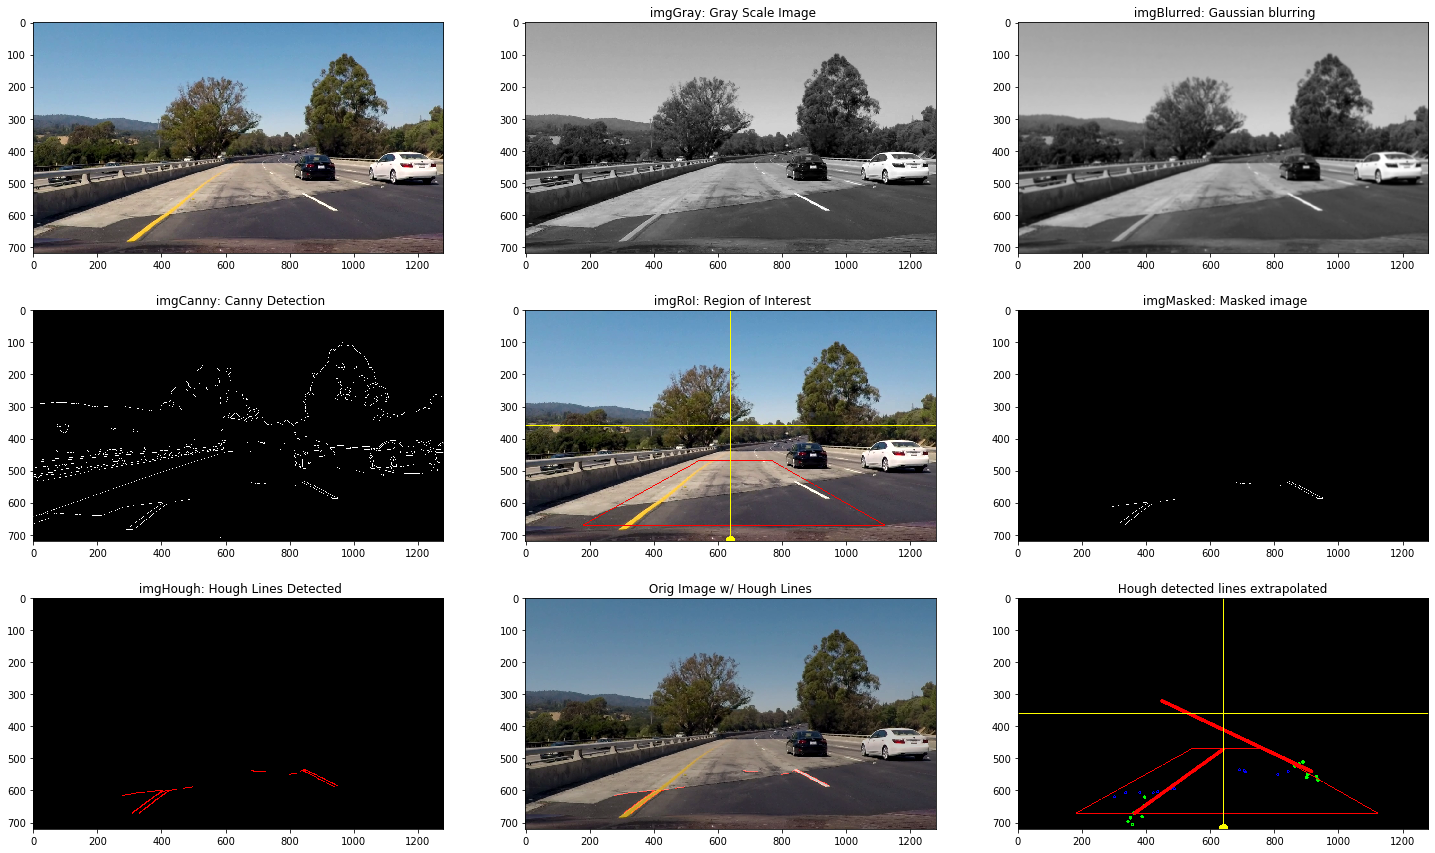

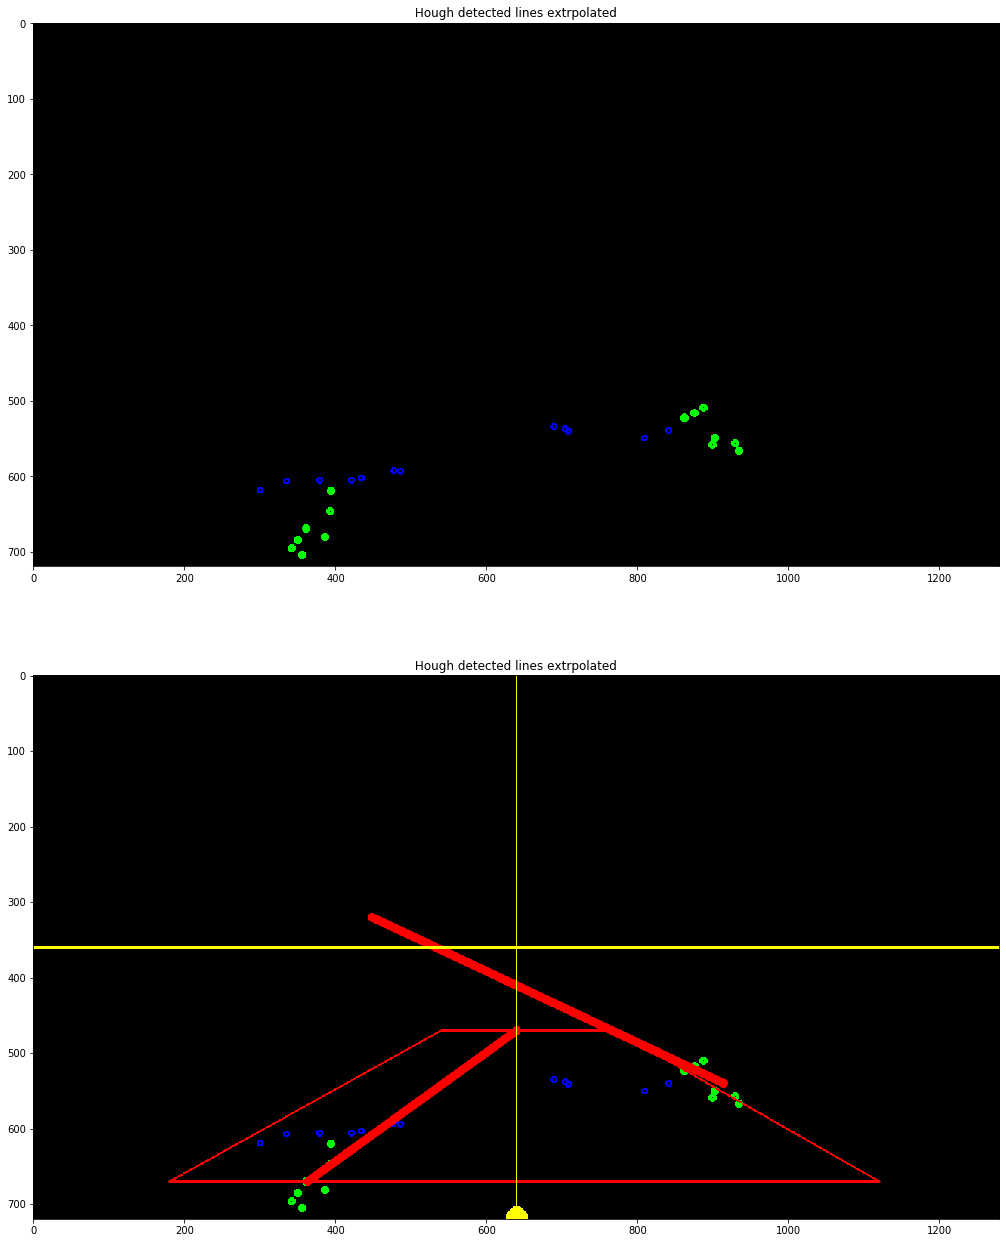

Text(0.5, 1.0, 'whiteCarLaneSwitch.jpg with detected lanes')

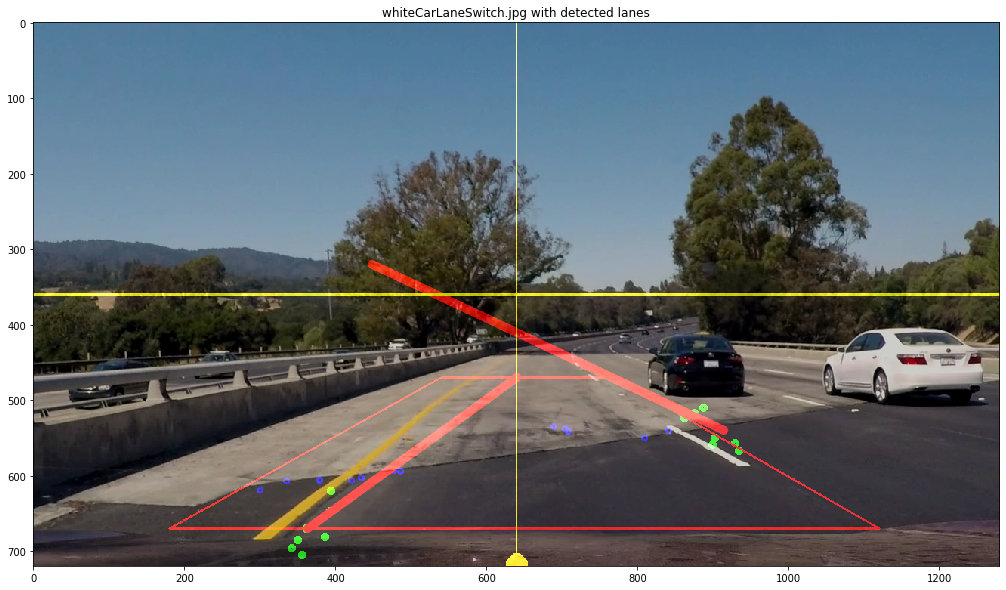

In [49]:
print(image.shape)
print('current frame: ', cap.get(1)-1, ' time(ms): ', cap.get(0),'    ',cap.get(2),cap.get(3),cap.get(4),cap.get(5),cap.get(6), cap.get(7), cap.get(cv2.CAP_PROP_FRAME_COUNT))
# imgBright = cv2.addWeighted( image,   1.5, image, 0, 50)
# imgGray = cv2.cvtColor(imgBright, cv2.COLOR_BGR2GRAY)

# plt.imshow(image);plt.show()
# plt.imshow(imgBright);plt.show()
# plt.imshow(imgGray, cmap='gray');plt.show()

print('   with dimensions:', image.shape)    
imgDetected = process_image_modified(image, debug= True)
fig = plt.figure(figsize=(20,10))
plt.imshow(imgDetected); plt.title(images[image_id]+' with detected lanes')